 - Currently uses the radius-as-a-function-of-B-mag for Tycho stars from the BOSS mask (in every band) to set the `NEAR_RADIUS`: R = (0.0802B*B - 1.860B + 11.625) (see Eqn. 9 of https://arxiv.org/pdf/1203.6594.pdf) and half that radius to set the `IN_RADIUS`. We convert this from arcminutes to arcseconds.

In [1]:
import os
import sys
import time

In [3]:
import pandas as pd
import numpy as np
from numpy import cos
from scipy.spatial import cKDTree

In [4]:
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import skimage.io
import cv2

In [5]:
LSLGAdir = os.getenv('LSLGA_DIR')
parent = os.path.join(LSLGAdir, 'sample', 'hyperleda-d25min10.fits')
tycho2 = os.path.join(LSLGAdir, 'sample', 'tycho2.kd.fits')

In [6]:
galaxies = Table(fitsio.read(parent, ext=1)).to_pandas()
tycho = Table(fitsio.read(tycho2, ext=1)).to_pandas()

In [7]:
tycho = tycho[tycho.ISGALAXY == 0]
tycho['radius'] = (0.0802*(tycho.MAG_BT)**2 - 1.860*tycho.MAG_BT + 11.625)/60 # in arcsec

In [ ]:
locations = np.array([galaxies.ra, galaxies.dec]).T
tree = cKDTree(locations)

In [8]:
start_time = time.time()

nearby = []

for star in tycho.itertuples():

    near_list = tree.query_ball_point((star.RA, star.DEC), r=star.radius)
    
    if len(near_list) > 0:
        keep = galaxies.loc[galaxies.index[near_list]]
        nearby.append(keep.index)
    
    if star.Index%10000 == 0:
        sys.stdout.write('\r')
        sys.stdout.write('{0:.{1}f} percent complete'.format(star.Index/len(tycho)*100, 2))
        sys.stdout.flush()

tocut = []
for ii in range(len(nearby)):
    tocut.append(nearby[ii][0])

check = galaxies.loc[tocut]

print('\r')
print('{0:.{1}f} seconds'.format(time.time() - start_time, 2))

99.71 percent complete
45.49 seconds


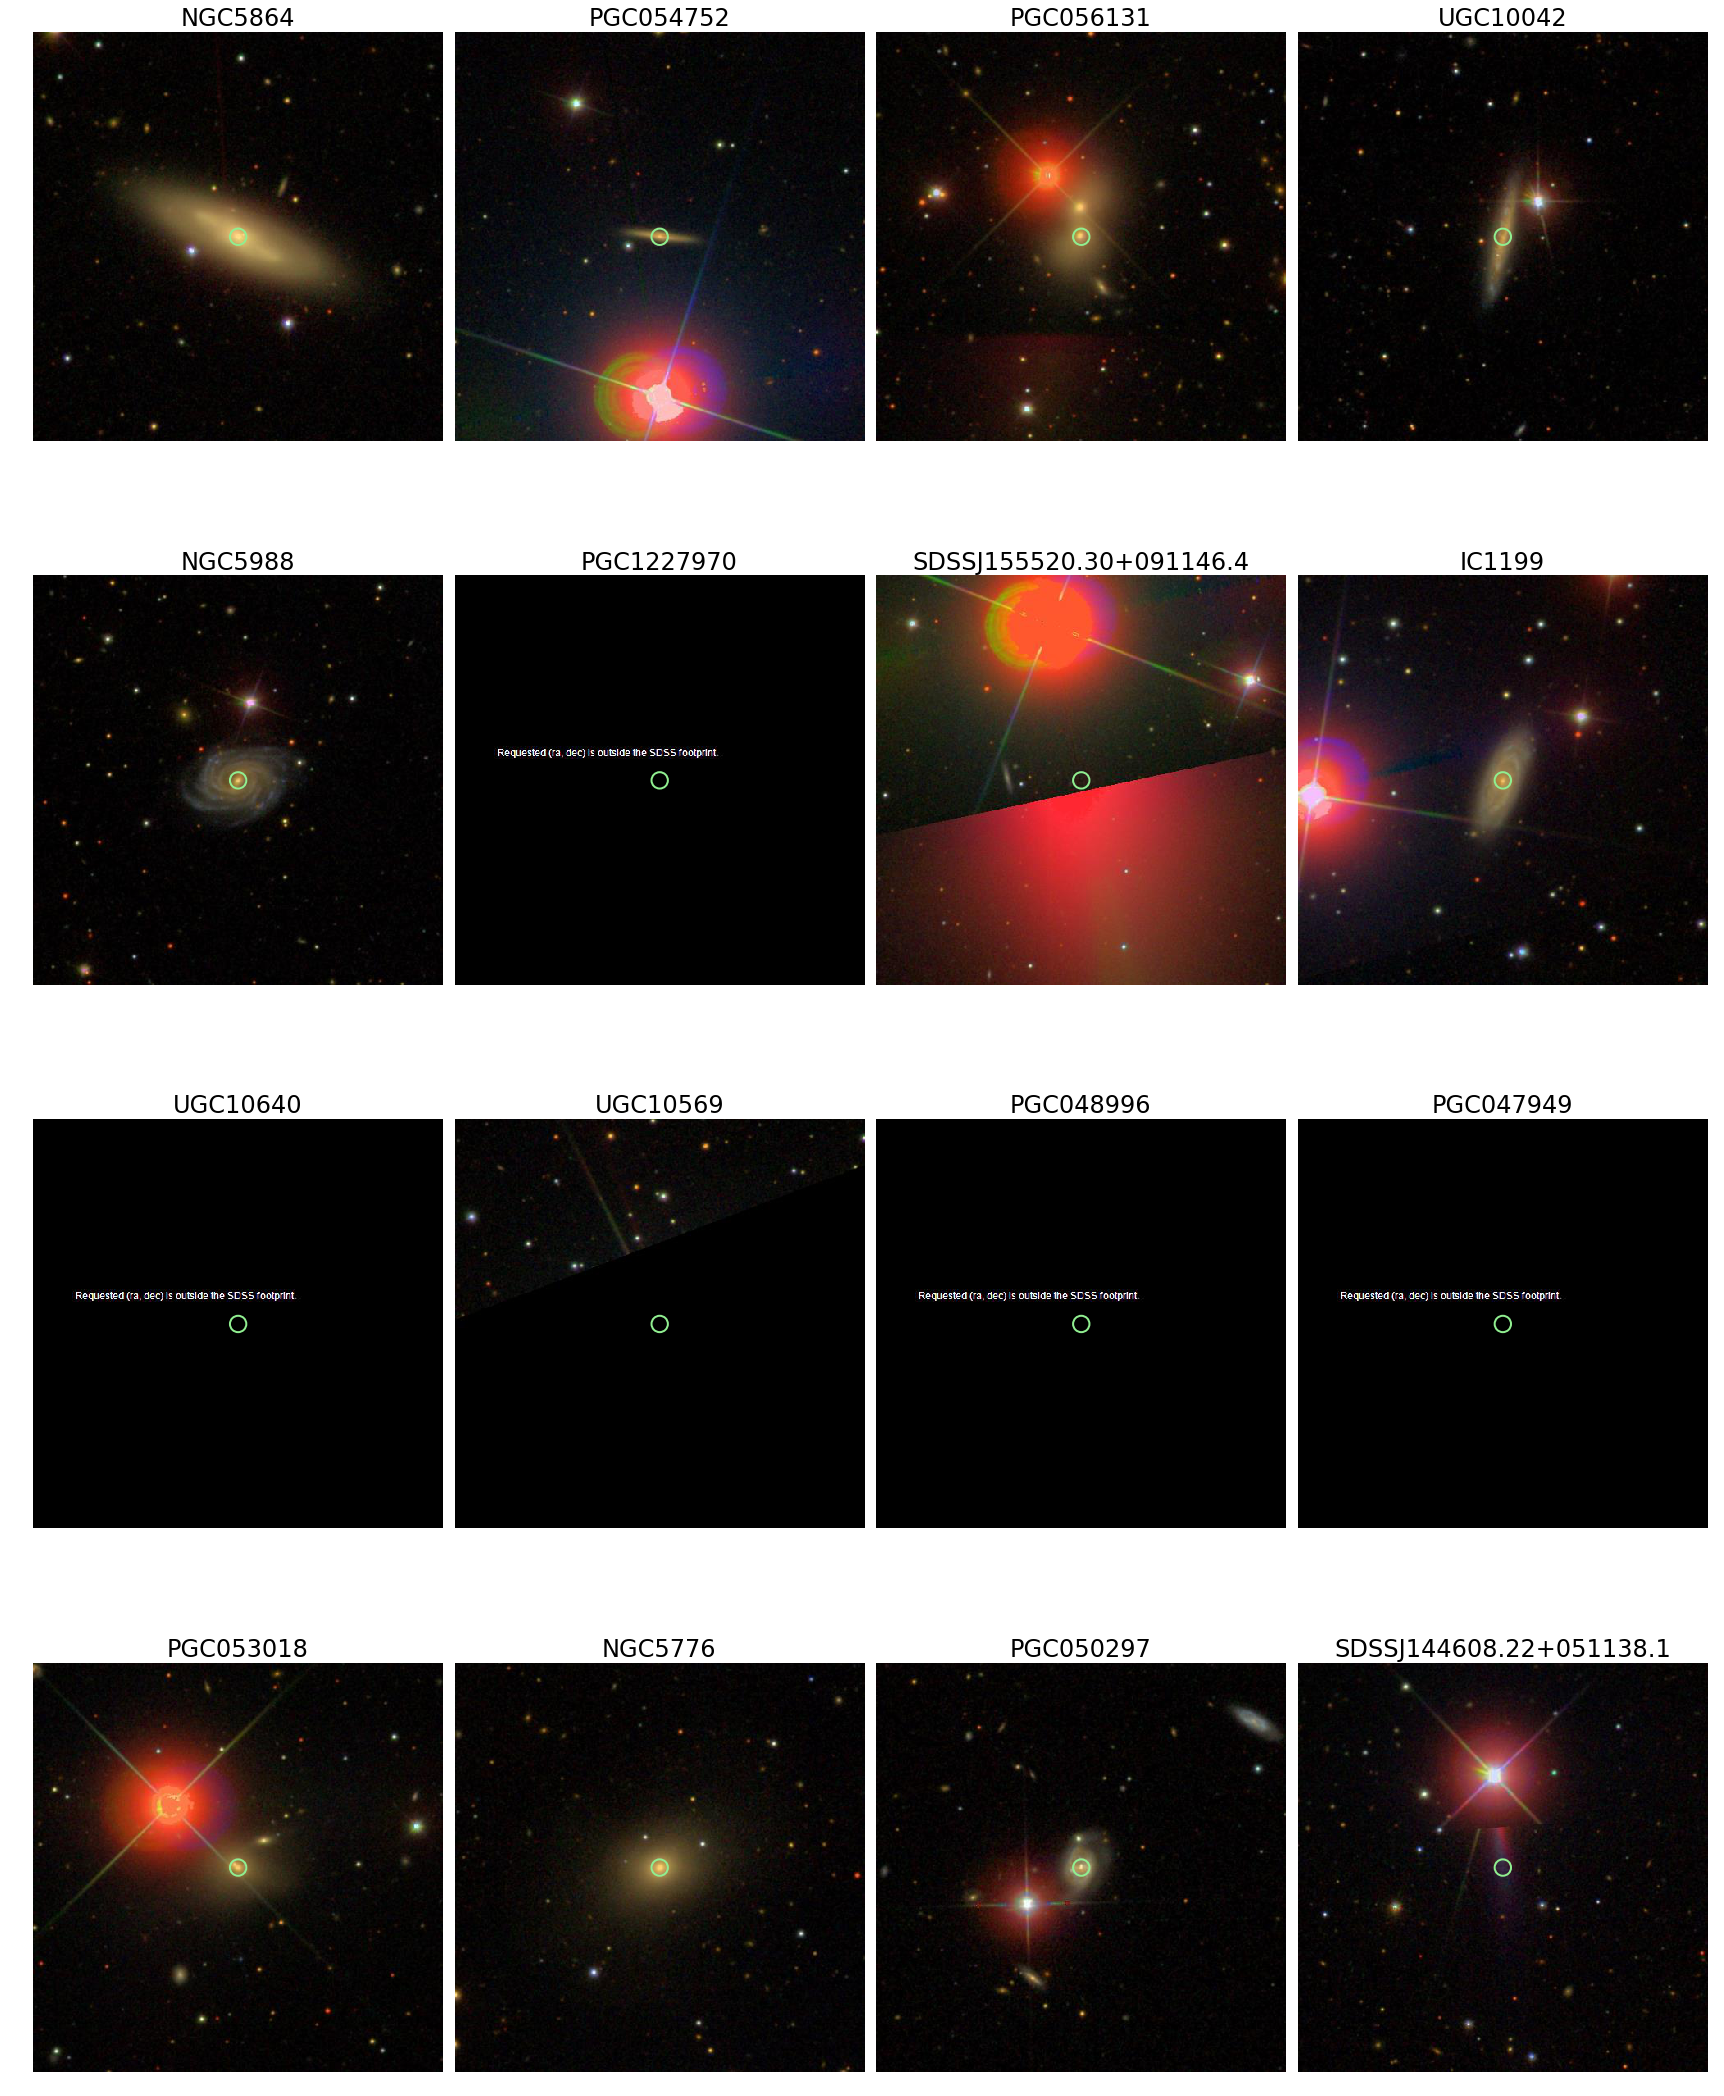

In [101]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

sample = check[:16]

width = 500
height = 500
pixelsize = 0.5 #0.396
plt.figure(figsize=(30, 2.5*len(sample)))
subPlotNum = 1

for idx, gal in sample.iterrows():

    #scale = (80*gal.d25)/pixelsize/width
    scale = (8000*np.degrees(1*(1/3600)))/pixelsize/width
    url = "http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx?ra="+str(gal['ra'])
    url += "&dec="+str(gal['dec'])+"&scale="""+str(scale)+"&width="+str(width)
    url += "&height="+str(height)
    
    img = skimage.io.imread(url)
    
    ax = plt.subplot(np.ceil(len(sample)/4), 4, subPlotNum)
    
    subPlotNum += 1  
    plt.axis('off')
    plt.imshow(img)
    
    circ = Circle((250, 250), 10, facecolor='none', edgecolor='lightgreen', linewidth=2)
    ax.add_patch(circ)
        
    # show the object identifier (objId) above the image.
    plt.title(gal.galaxy.decode('utf-8'), fontsize=24)
    
    plt.subplots_adjust(wspace=0.03, hspace=0)

## Some snippets that may come in handy some day

In [8]:
#ramod = tycho.RA * cos(tycho.DEC)
#locations = np.array([ramod, tycho.DEC]).T
locations = np.array([tycho.RA, tycho.DEC]).T
tree = cKDTree(locations)

In [11]:
centers = np.array([galaxies.ra, galaxies.dec]).T

In [11]:
nearby = []
for gal in galaxies.itertuples():

    ra = gal.ra
    dec = gal.dec
    
    point = (ra, dec)
    #point = (ra * cos(dec), dec)
    near_list = tree.query_ball_point(point, r=50/3600)
    
    if len(near_list) > 0:
        keep = tycho.loc[tycho.index[near_list]]
        nearby.append([gal.Index, keep.index])
        
tocut = []
for ii in range(len(nearby)):
    tocut.append(nearby[ii][0])
    
check = galaxies.loc[tocut]
check.head()

,galaxy,pgc,objtype,ra,dec,type,bar,ring,multiple,compactness,...,w4sigm,tmass_key,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,inwise,groupid
4,b'UGC12897',54,b'G',0.158084,28.384472,b'Sab',b'nan',b'nan',b'nan',b'nan',...,0.191,350118791,13.254,0.061,12.549,0.07,12.226,0.055,True,4
54,b'PGC000538',538,b'G',1.745315,-6.955643,b'SABd',b'B',b'nan',b'M',b'nan',...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,True,55
122,b'UGC00160',1128,b'G',4.265475,34.499482,b'Sd',b'nan',b'R',b'nan',b'nan',...,0.000,0,0.000,0.000,0.000,0.00,0.000,0.000,False,124
147,b'PGC001294',1294,b'G',4.993215,19.402399,b'Sc',b'nan',b'nan',b'nan',b'nan',...,0.000,0,0.000,0.000,0.000,0.00,0.000,0.000,False,149
195,b'PGC001634',1634,b'G',6.572656,-4.492326,b'SBa',b'B',b'nan',b'nan',b'nan',...,0.043,82591692,14.890,0.161,14.085,0.18,13.727,0.134,True,198


In [494]:
indices = []
groups = []
allinfo = []
for ii, stars in enumerate(nearby):
    if len(stars) > 0:
        indices.append(ii)
        groups.append(stars)
        allinfo.append([ii, stars])

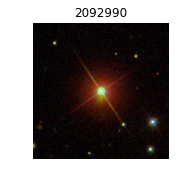

In [56]:
sample = problems[problems.index == 2092990]

width = 500
height = 500
pixelsize = 0.5 #0.396
plt.figure(figsize=(30, 2.5*len(sample)))
subPlotNum = 1

for idx, gal in sample.iterrows():

    #scale = (80*gal.d25)/pixelsize/width
    scale = 0.25
    url = "http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx?ra="+str(gal['RA'])
    url += "&dec="+str(gal['DEC'])+"&scale="""+str(scale)+"&width="+str(width)
    url += "&height="+str(height)
    
    img = skimage.io.imread(url)
    
    ax = plt.subplot(np.ceil(len(sample)/4), 4, subPlotNum)
    
    subPlotNum += 1  
    plt.axis('off')
    plt.imshow(img)
    
    circ = Circle((250, 250), 10, facecolor='none', edgecolor='lightgreen', linewidth=2)
    ax.add_patch(circ)
    
    #for ii, _ in enumerate(groups[idx]):
    #    obj = tycho.loc[groups[idx][ii]]
    #    radiff = gal.ra - obj.RA
    #    decdiff = gal.dec - obj.DEC
    #    circ2 = Circle((250-(radiff/scale)*cos(obj.DEC), 250+decdiff/scale), 10, 
    #                  facecolor='none', edgecolor='red', linewidth=2)
    #    ax.add_patch(circ2)
        
    # show the object identifier (objId) above the image.
    #plt.title(gal.galaxy.decode('utf-8'), fontsize=24)
    plt.title(idx)
    plt.subplots_adjust(wspace=0.03, hspace=0)